In [2]:
from astropy.table import Table, QTable
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM, LambdaCDM
import math
from astropy import units as u
import numpy as np
import scipy
from scipy import integrate
from pylab import *
from matplotlib.font_manager import fontManager, FontProperties

#Table input
t = Table.read('scp.dat',names=("SN","z","sigma z","m X peak","sigma X peak","A X","K BX","m B peak","m B eff","sigma m B eff"), format='ascii')


In [3]:
#X and Y Input 
x = t["z"]
y = t["m B eff"]
zandmb = t["z","m B eff"].as_array()
inner_err = t["sigma X peak"] # inner y error bar
outer_err = t["sigma m B eff"] # outer y error bar
shift_err = t["sigma z"] # x axis error bar
print(zandmb)

[(0.458, 23.11) (0.354, 22.38) (0.425, 22.13) (0.374, 21.72)
 (0.42 , 22.55) (0.372, 22.26) (0.378, 22.58) (0.453, 23.17)
 (0.465, 23.33) (0.498, 23.71) (0.655, 23.27) (0.4  , 22.36)
 (0.615, 23.19) (0.48 , 22.96) (0.45 , 22.51) (0.388, 22.65)
 (0.57 , 23.27) (0.49 , 23.1 ) (0.495, 22.83) (0.656, 23.57)
 (0.828, 24.65) (0.45 , 23.17) (0.43 , 23.13) (0.58 , 23.46)
 (0.763, 24.47) (0.526, 23.15) (0.172, 20.17) (0.619, 23.8 )
 (0.592, 24.42) (0.55 , 23.51) (0.18 , 20.43) (0.374, 23.52)
 (0.472, 23.11) (0.43 , 22.57) (0.657, 23.83) (0.612, 23.69)
 (0.32 , 21.86) (0.579, 23.48) (0.45 , 22.83) (0.581, 23.09)
 (0.416, 22.57) (0.83 , 24.32)]


In [4]:
#(Omega M, Omega A)

#(0,1)
cosmo_fa = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0, Ode0=1)
#(0.5,0.5)
cosmo_fb = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0.5, Ode0=0.5)
#(1,0)
cosmo_fc = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=1, Ode0=0)
#(1.5,-0.5)
cosmo_fd = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=1.5, Ode0=-0.5)
#(0,0)
cosmo_e = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=0, Ode0=0)
#(1,0)
cosmo_f = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=1, Ode0=0)
#(2,0)
cosmo_g = LambdaCDM(H0=70* u.km / u.s / u.Mpc, Om0=2, Ode0=0)

In [5]:
def DM(x):
    
    d_t = cosmo_fa.comoving_transverse_distance(x)
    
    d_a = d_t / (1+x)

    # LUMINOSITY DISTANCE
    d_l = (1+x) * d_t

    # DISTANCE MODULUS
    dm = 5.0 * np.log10(d_l*10**6/10) # 1 Mpc = 10**6 pc
    k = x/(10*u.parsec)
    hm = 5*math.log(k)
    return hm
    

In [6]:
def get_cosmology(H0, omega_m, omega_k, omega_lambda,z):

    c = 299797.                  # VELOCITY OF LIGHT IN Km/s

    # HUBBLE CONSTANT IN STANDARD UNITS - DIMENSIONS sec-1
    H0_std = (H0/(3.08568025 * 10**19))

    # HUBBLE DISTANCE IN Mpc
    d_h = c/H0

        # SCIPY RETURNS THE INTEGRATION RESULT AS A TWO DIMENSIONAL ARRAY. FIRST ELEMENT IS THE RESULT. SECOND ELEMENT IS THE ERROR ASSOCIATED
    def e_z(z):
        return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))

    e_z_int, e_z_int_err = integrate.quad(e_z,0.,z)

    # TOTAL LINE-OF-SIGHT COMOVING DISTANCE 
    d_c = d_h * e_z_int

    # TRANSVERSE COMOVING DISTANCE
    if (omega_k==0.0):
        d_t = d_c
    elif (omega_k>0.0):
        d_t = d_h/math.sqrt(omega_k) * math.sinh(math.sqrt(omega_k)*d_c/d_h)
    else:
        d_t = d_h/math.sqrt(abs(omega_k)) * math.sinh(math.sqrt(abs(omega_k))*d_c/d_h)

    if (omega_lambda==0.0):
        d_t = d_h * 2 *(2 - (omega_m *(1-z)) - ((2-omega_m) * (math.sqrt(1+(omega_m*z))))) / (omega_m**2 * (1+z))

    # ANGULAR DIAMETER DISTANCE
    d_a = d_t / (1+z)

    # LUMINOSITY DISTANCE
    d_l = (1+z) * d_t

    # DISTANCE MODULUS
    dm = 5.0 * np.log10(d_l*10**6/10) # 1 Mpc = 10**6 pc
    mag_fit=-3.17+ (5.*np.log10(d_l*H0))
    return mag_fit
    
####################################################################################
####################################################################################

def make_fit_plot(zarr, H0, omega_m, omega_k, omega_lambda, color_val='r', extra_lab=''): # default plot color is red

    zarr = sorted(zarr) #sort the redshift array
    d_l_arr = []
    for zval in zarr:
        d_l = get_cosmology(H0, omega_m, omega_k, omega_lambda, zval)
        d_l_arr.append( d_l )

    d_l_arr = np.asarray(d_l_arr)

        
    #mag_fit=((-19.0)-(5.*np.log10(H0)+25.))+ 5.*np.log10(d_l[:]*H0)
    mag_fit=-3.17+ (5.*np.log10(d_l_arr*H0)) # -3.17 is a fit parameters I think - check the paper
    semilogx(zarr, mag_fit, ls='solid', lw=1., color=color_val, label='%s$\Omega$$_{\Lambda}$ = %s ; $\Omega$$_{m}$ = %s' %(extra_lab,omega_lambda,omega_m))

####################################################################################


In [7]:
scp=np.loadtxt('scp_table.dat')  # I read the data here

z = scp[:,1]
z = sorted(z)
m_b_eff =scp[:,9]

#zandmb = np.sort(zandmb)
#print(zandmb)
#for i,j  in zandmb:
#    print(i)
#    print(j-get_cosmology(71,0.5,0,1,i))
        
    
    
    
def chi_squar(zandmbf, H0, omega_m, omega_k, omega_lambda):
    zandmb = np.sort(zandmbf)
    chi_x =[]
    chi_x= sorted(chi_x)
    for i,j in zandmb:
        z = i
        model = get_cosmology( H0, omega_m, omega_k, omega_lambda,i)
        data = j
        chi= ((data - model)**2)/model
        chi_x.append(chi)
   
    return chi_x

def chi_plot(zandmbf, H0, omega_m, omega_k, omega_lambda,coor):
    yy = sorted(chi_squar(zandmbf, H0, omega_m, omega_k, omega_lambda),reverse=True)
    xf = plt.plot(z,jio,color=coor)
    return xf
  

models = [(0,0,1),(0.5,0,0.5),(1,0,0),(0.27,0,0.73),(1.5,0,-0.5),(0,0,0),(2,0,0)]
valuex = []
for q,w,ke in models:
    ho = 71
    zx =zandmb
    print
    #mxe = chi_squar(zx,71,q,w,ke)
    #sm = sum(mxe)
    #valuex.append(sm)
mx = chi_squar(zandmb,71,1,0,0)    
print(mx)
plt.figure(figsize=(9,6))




[0.004579768082232736, 0.0010715152337799252, 2.9426656866343842e-05, 0.0031166715018090814, 3.5863941084570256e-05, 0.01235009620799483, 0.07318028933755366, 0.004352077862021562, 0.004614799043238388, 6.938434286983146e-05, 0.00028291799103589553, 6.276553433204679e-05, 0.007452400528725607, 4.0439587149996104e-07, 0.014046743338447104, 0.0011654521054649117, 0.0010933602526769178, 0.010914191983929483, 0.010239943810013459, 0.006920584627218818, 0.014847888200932764, 0.004675931406291958, 0.0008253038794381834, 0.002296397746915275, 0.00018176593497209128, 0.028034336679095915, 0.0005601094413547505, 0.005888567696009042, 8.872041818075972e-05, 0.002054712721163591, 0.0016271984514921508, 0.0013842727918376388, 0.052513091492070015, 0.0038049138793191948, 0.0019417429823292138, 0.006217024776555283, 0.003368492800369211, 9.221582866542123e-06, 0.003120656182822815, 0.01298208080159792, 0.012223594783641172, 0.001778687035753968]


<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

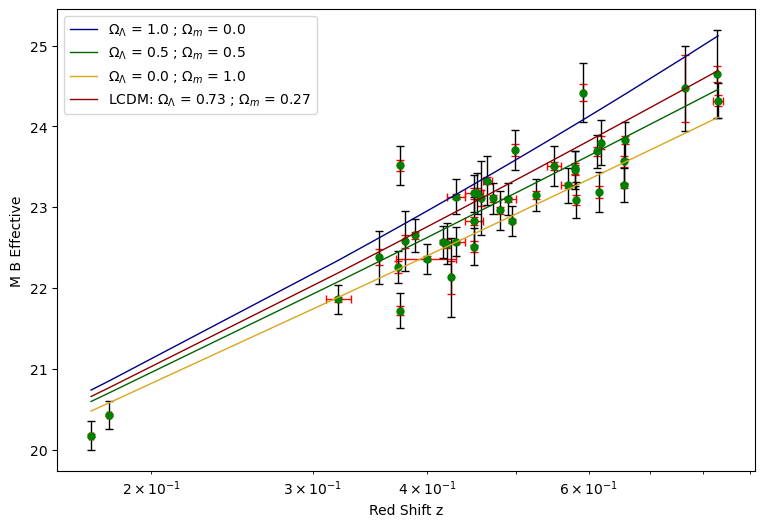

In [14]:

plt.figure(figsize=(9,6))

plt.errorbar(x,y,xerr = shift_err,yerr = inner_err, marker='',linestyle='none', ecolor='red',elinewidth=1, capsize=3,capthick=1  )
plt.errorbar(x,y,yerr = outer_err, marker='',linestyle='none', ecolor='black',elinewidth=1, capsize=3,capthick=1  )

#plt.plot(x, ca, color='blue', linestyle='dashed',linewidth=2, markersize=5)

plt.plot(x, y, color='green', marker='o', linestyle='none',linewidth=2, markersize=5)

#plt.plot(x, a(x), label = 'trapezoid')
H0=71.
omega_k=0.
#Make Fits with different parameters
#Fit 1:
omega_m=0.
omega_lambda=1.0

make_fit_plot(x, H0, omega_m, omega_k, omega_lambda, color_val = 'navy')

#Fit 2:
omega_m=0.5
omega_lambda=0.5

make_fit_plot(x, H0, omega_m, omega_k, omega_lambda, color_val='darkgreen')

#Fit 3:
omega_m=1.0
omega_lambda=0.0

make_fit_plot(x, H0, omega_m, omega_k, omega_lambda, color_val='goldenrod')

#Fit 4: LCDM
omega_m=0.27
omega_lambda=0.73

make_fit_plot(x, H0, omega_m, omega_k, omega_lambda, color_val='darkred', extra_lab='LCDM: ')



plt.xlabel('Red Shift z')
plt.ylabel('M B Effective')
plt.legend(loc=2)


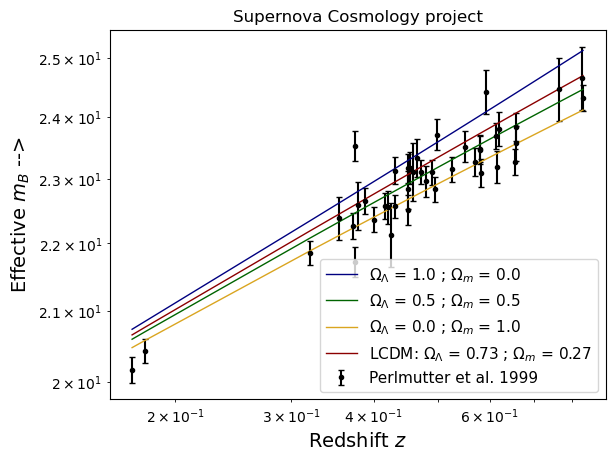

In [13]:
def get_cosmology(H0, omega_m, omega_k, omega_lambda,z):

    c = 299797.                  # VELOCITY OF LIGHT IN Km/s

    # HUBBLE CONSTANT IN STANDARD UNITS - DIMENSIONS sec-1
    H0_std = (H0/(3.08568025 * 10**19))

    # HUBBLE DISTANCE IN Mpc
    d_h = c/H0

        # SCIPY RETURNS THE INTEGRATION RESULT AS A TWO DIMENSIONAL ARRAY. FIRST ELEMENT IS THE RESULT. SECOND ELEMENT IS THE ERROR ASSOCIATED
    def e_z(z):
        return (1.0/math.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_lambda))

    e_z_int, e_z_int_err = integrate.quad(e_z,0.,z)

    # TOTAL LINE-OF-SIGHT COMOVING DISTANCE 
    d_c = d_h * e_z_int

    # TRANSVERSE COMOVING DISTANCE
    if (omega_k==0.0):
        d_t = d_c
    elif (omega_k>0.0):
        d_t = d_h/math.sqrt(omega_k) * math.sinh(math.sqrt(omega_k)*d_c/d_h)
    else:
        d_t = d_h/math.sqrt(abs(omega_k)) * math.sinh(math.sqrt(abs(omega_k))*d_c/d_h)

    if (omega_lambda==0.0):
        d_t = d_h * 2 *(2 - (omega_m *(1-z)) - ((2-omega_m) * (math.sqrt(1+(omega_m*z))))) / (omega_m**2 * (1+z))

    # ANGULAR DIAMETER DISTANCE
    d_a = d_t / (1+z)

    # LUMINOSITY DISTANCE
    d_l = (1+z) * d_t

    # DISTANCE MODULUS
    dm = 5.0 * np.log10(d_l*10**6/10) # 1 Mpc = 10**6 pc
    
    return d_l
    
####################################################################################
####################################################################################

def make_fit_plot(zarr, H0, omega_m, omega_k, omega_lambda, color_val='r', extra_lab=''): # default plot color is red

    zarr = sorted(zarr) #sort the redshift array
    d_l_arr = []
    for zval in zarr:
        d_l = get_cosmology(H0, omega_m, omega_k, omega_lambda, zval)
        d_l_arr.append( d_l )

    d_l_arr = np.asarray(d_l_arr)

        
    #mag_fit=((-19.0)-(5.*np.log10(H0)+25.))+ 5.*np.log10(d_l[:]*H0)
    mag_fit=-3.17+ (5.*np.log10(d_l_arr*H0)) # -3.17 is a fit parameters I think - check the paper
    semilogx(zarr, mag_fit, ls='solid', lw=1., color=color_val, label='%s$\Omega$$_{\Lambda}$ = %s ; $\Omega$$_{m}$ = %s' %(extra_lab,omega_lambda,omega_m))

####################################################################################
####################################################################################

import numpy as np
import scipy
from scipy import integrate
from pylab import *
from matplotlib.font_manager import fontManager, FontProperties

scp=np.loadtxt('scp_table.dat')  # I read the data here

z = scp[:,1] # second column in the file is the redshift - remember python starts with column 0
mag, mag_err = scp[:,8], scp[:,9] # magnitude and the associated errors from 9th/10th columns

clf()
ax=subplot(111, yscale='log')
#semilogx(z, mag, 'ko', label='Perlmutter et al. 1999') # Plot the data
errorbar(z, mag, yerr=mag_err, marker = '.', color='k', capsize = 2., label='Perlmutter et al. 1999', ls = 'None') # Plot the data

H0=71.
omega_k=0.
#Make Fits with different parameters
#Fit 1:
omega_m=0.
omega_lambda=1.0

make_fit_plot(z, H0, omega_m, omega_k, omega_lambda, color_val = 'navy')

#Fit 2:
omega_m=0.5
omega_lambda=0.5

make_fit_plot(z, H0, omega_m, omega_k, omega_lambda, color_val='darkgreen')

#Fit 3:
omega_m=1.0
omega_lambda=0.0

make_fit_plot(z, H0, omega_m, omega_k, omega_lambda, color_val='goldenrod')

#Fit 4: LCDM
omega_m=0.27
omega_lambda=0.73

make_fit_plot(z, H0, omega_m, omega_k, omega_lambda, color_val='darkred', extra_lab='LCDM: ')

xlabel('Redshift $z$', fontsize=14)
ylabel('Effective $m_{B}$ -->', fontsize=14)
title('Supernova Cosmology project')
legend(loc=4, fancybox=True, fontsize = 11)
savefig('sne_distance_magnitude_cosmo.png', dpi=200.)